<a href="https://colab.research.google.com/github/ad709kr/NYC-Taxi-Trip-Time-Predction/blob/main/NYC_trip_time_prediction_individual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Name    -  NYC Taxi Trip Time Prediction 

## Project Summary 
Task  is to build model to predicts the total ride duration of taxi trip in the New York city.Your primary dataset is one released by NYC Taxi and Limousine commission, which includes pickup time, geo-coordinates, number of passengers, and total other variables.

## Problem statement
Given the dataset, we have to predict the taxi trip duration.

## Dataset description  
**id** - a unique identifier for each trip
<br>**vendor_id** - a code indicating the provider associated with the trip record
<br>**pickup_datetime** - date and time when the meter was engaged
<br>**dropoff_datetime** - date and time when the meter was disengaged
<br>**passenger_count** - the number of passengers in the vehicle (driver entered value)
<br>**pickup_longitude** - the longitude where the meter was engaged
<br>**pickup_latitude** - the latitude where the meter was engaged
<br>**dropoff_longitude** - the longitude where the meter was disengaged
<br>**dropoff_latitude** - the latitude where the meter was disengaged
<br>**store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward 
<br>**trip_duration** - duration of the trip in seconds




## Importing Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.distance import great_circle
from math import radians, sin, cos, atan2,sqrt
from scipy import stats
import scipy

from sklearn.preprocessing import StandardScaler
import folium # to plot street map
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer


## Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file = '/content/drive/MyDrive/Almabetter/regression_project/Copy of NYC Taxi Data.csv'
df = pd.read_csv(file)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
print("The shape of dataset is ",df.shape)

The shape of dataset is  (1458644, 11)


In [5]:
# Checking null values
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
# checking duplicate
df[df.duplicated()].count()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

**observation**
<br> There is no null, duplicate items in the dataset. Two features which needs to be converted in to the date_time function and to extract some features from that.

In [8]:
# Lets convert pickup_datetime and drop_off datetime to datetime functions
df['pickup_datetime'] = pd.to_datetime(df["pickup_datetime"])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])
#df = pd.to_datetime(df["dropoff_datetime"])

**Feature extraction**


In [9]:
# date_time to day
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

In [10]:
# date_time to month
df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

df['pickup_hour']=df['pickup_datetime'].dt.hour
df['dropoff_hour']=df['dropoff_datetime'].dt.hour

df['pickup_minute']=df['pickup_datetime'].dt.minute
df['dropoff_minute']=df['dropoff_datetime'].dt.minute

In [11]:
def great_circle_distance(pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude):
  pickup = (pickup_latitude,pickup_longitude)
  dropoff = (dropoff_latitude,dropoff_longitude)
  return great_circle(pickup,dropoff).miles

'''def second_distance(pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude):
  r = 6371.0
  pickup_lat = radians(pickup_latitude)
  pickup_lon = radians(pickup_longitude)
  
  dropoff_lat = radians(dropoff_latitude)
  dropoff_lon = radians(dropoff_longitude)

  dis_lat = dropoff_lat-pickup_lat
  dis_long = dropoff_lon-pickup_lon

  a = sin(dis_lat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dis_long / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a)) 


  return r*c'''

'def second_distance(pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude):\n  r = 6371.0\n  pickup_lat = radians(pickup_latitude)\n  pickup_lon = radians(pickup_longitude)\n  \n  dropoff_lat = radians(dropoff_latitude)\n  dropoff_lon = radians(dropoff_longitude)\n\n  dis_lat = dropoff_lat-pickup_lat\n  dis_long = dropoff_lon-pickup_lon\n\n  a = sin(dis_lat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dis_long / 2)**2\n  c = 2 * atan2(sqrt(a), sqrt(1 - a)) \n\n\n  return r*c'

In [12]:
df['trip_distance'] = df.apply(lambda x : great_circle_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis = 1)

In [13]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_minute,dropoff_minute,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,3,17,17,24,32,0.931139
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0,43,54,1.121892
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12,35,10,3.967522
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,4,4,19,19,32,39,0.923047
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,3,3,13,13,30,38,0.738556


In [14]:
df.dtypes.value_counts()

int64             9
float64           5
object            4
datetime64[ns]    2
dtype: int64

In [15]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_minute,dropoff_minute,trip_distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.516818e+00,3.517178e+00,1.360648e+01,1.359890e+01,2.959016e+01,2.962843e+01,2.138057e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.681038e+00,1.681217e+00,6.399693e+00,6.483682e+00,1.732471e+01,1.742023e+01,2.669749e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,2.000000e+00,2.000000e+00,9.000000e+00,9.000000e+00,1.500000e+01,1.500000e+01,7.654288e-01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,4.000000e+00,4.000000e+00,1.400000e+01,1.400000e+01,3.000000e+01,3.000000e+01,1.300977e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,5.000000e+00,1.900000e+01,1.900000e+01,4.500000e+01,4.500000e+01,2.408026e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,7.000000e+00,2.300000e+01,2.300000e+01,5.900000e+01,5.900000e+01,7.710660e+02


there are some trip having trip distance and trip duration equal to zero and some have very large value.

In [16]:
# Lets count total trips having trip_duration or trip_distance equals to zero
'''
trip_zero_dur = 0
trip_zero_dis = 0
for val in df['trip_distance']:
  if val == 0:
    trip_zero_dis += 1
for val in df['trip_duration']:
  if val == 0:
    trip_zero_dur += 1
print(trip_zero_dur)
print(trip_zero_dis)'''

"\ntrip_zero_dur = 0\ntrip_zero_dis = 0\nfor val in df['trip_distance']:\n  if val == 0:\n    trip_zero_dis += 1\nfor val in df['trip_duration']:\n  if val == 0:\n    trip_zero_dur += 1\nprint(trip_zero_dur)\nprint(trip_zero_dis)"

<br> No trip can be possible if trip distance equal to zero, but from the data it is showing that total 5897 records have zero distance it could be either because :

*   Driver forgets to keep track of the distance
*   driver deliberately not entered to complete its daily target.
<br> So, In these case either we can impute these values or remove the records.
<br> since mean, median both values are different and 5897 records is very less compare to the total records so we removed it.



**outlier removal:** 
<br>we will follow two approach to remove outlier. The final dataset will be that having less data loss from the above two approaches.

**Outlier removal using inter quantile range**

In [17]:
#outlier removal
"""
def upper_lower_range(df,col):
  quantile_1 = df[col].quantile(0.25)
  quantile_3 = df[col].quantile(0.75)
  iqr = quantile_3-quantile_1
  lower1 =  quantile_1 - 1.5 * iqr
  if lower1 < 0 :
    lower = 0
  else:
    lower = lower1
  upper = quantile_3 + 1.5 * iqr
  return lower,upper


lower_lim, upper_lim = upper_lower_range(df,'trip_distance')
lower_lim_dur,upper_lim_dur = upper_lower_range(df,'trip_duration')
"""


"\ndef upper_lower_range(df,col):\n  quantile_1 = df[col].quantile(0.25)\n  quantile_3 = df[col].quantile(0.75)\n  iqr = quantile_3-quantile_1\n  lower1 =  quantile_1 - 1.5 * iqr\n  if lower1 < 0 :\n    lower = 0\n  else:\n    lower = lower1\n  upper = quantile_3 + 1.5 * iqr\n  return lower,upper\n\n\nlower_lim, upper_lim = upper_lower_range(df,'trip_distance')\nlower_lim_dur,upper_lim_dur = upper_lower_range(df,'trip_duration')\n"

In [18]:
#print(lower_lim) 
#print(upper_lim)

In [19]:
# outlier removal using trip_distance
#new_df = df[(df['trip_distance'] > lower_lim) & (df['trip_distance'] <= upper_lim)]
#new_df = new_df[(new_df['trip_duration'] > lower_lim_dur) & new_df['trip_duration'] < upper_lim_dur] 

In [20]:
#data_loss = df.shape[0]-new_df.shape[0]
#print(" the data loss using iqr outlier removal technique is", data_loss*100/df.shape[0],"%")

**outlier removal using mean and variance**

In [21]:
"""def outlier_removal_tech(df,col):
  mean = df[col].mean()
  s = df[col].std()
  low_lim = mean - 2*s
  if low_lim <0 :
    lower_limit = 0
  else:
    lower_limit = low_lim
  upper_limit = mean + 2*s
  #print(lower_limit)
  #print(upper_limit)
  new_df = df[(df[col] > lower_limit) & (df[col] < upper_limit)]
  return new_df
new_data = outlier_removal_tech(df,'trip_distance')
new_data1 = outlier_removal_tech(new_data,'trip_duration')"""

"def outlier_removal_tech(df,col):\n  mean = df[col].mean()\n  s = df[col].std()\n  low_lim = mean - 2*s\n  if low_lim <0 :\n    lower_limit = 0\n  else:\n    lower_limit = low_lim\n  upper_limit = mean + 2*s\n  #print(lower_limit)\n  #print(upper_limit)\n  new_df = df[(df[col] > lower_limit) & (df[col] < upper_limit)]\n  return new_df\nnew_data = outlier_removal_tech(df,'trip_distance')\nnew_data1 = outlier_removal_tech(new_data,'trip_duration')"

In [22]:
"""data_loss2 = df.shape[0] - new_data1.shape[0]
print("the data loss is",data_loss2*100/df.shape[0],"%")"""

'data_loss2 = df.shape[0] - new_data1.shape[0]\nprint("the data loss is",data_loss2*100/df.shape[0],"%")'

data loss is lesser in second approach, so we use the data obtained by second approach to do further analysis.

In [23]:
#sns.histplot(data = new_data1, x = 'trip_distance',kde = True, stat = 'probability')

In [24]:
#b = np.array(new_data1['trip_distance'])
#fitted_data, fitted_lambda = stats.boxcox(b)
#new_data1['trip_distance'] = list(fitted_data)
#sns.histplot(data = fitted_data, x =fitted_data,kde = True, stat = 'probability')

In [25]:
#sns.distplot(new_data1['trip_distance'], kde = True)

we will not apply any transform on our target variable.

## Exploratory data analysis

In [26]:
# list of the columns
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_month',
       'dropoff_month', 'pickup_hour', 'dropoff_hour', 'pickup_minute',
       'dropoff_minute', 'trip_distance'],
      dtype='object')

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_day          1458644 non-null  object        
 12  dropoff_day         1458644 non-null  object        
 13  pickup_month

**Univariate analysis**

**1.Vendor_id :** Different vendors who provide taxi service.


In [28]:
# Counting the unique value of each feature
df['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Vendor_id')

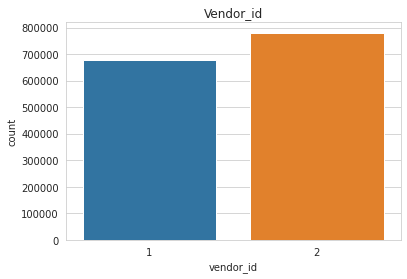

In [29]:
# vendor_id
sns.set_style('whitegrid')
sns.countplot(df['vendor_id'])
plt.title("Vendor_id")

**observation :** there are two vendors. vendor having vendor_id 2 has maximum number of trip.

**2. passenger count**
-Total number of pessangers in taxi during trip.

In [30]:
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [31]:
print(df.shape)

(1458644, 20)


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


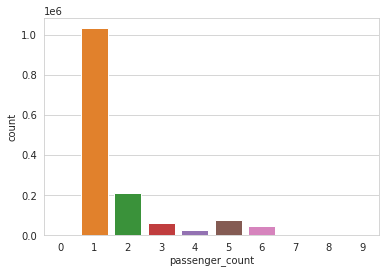

In [32]:
# passenger_count
sns.countplot(df['passenger_count'])

**Observation :** 
<br>(1) 60 trip contain zero passenger, 3 times 7 and 1 times 8 and 9 passengers.
<br>(2) AS per NYC taxi cab, the maximum number allowed are 5 adult and 1 child, so total 6 passeger, so rest are outliers.
<br>(3) There 60 trips with zero pessanger, so it might be mistaken so it can be treated as outliers.

In [33]:
#new_data1 = new_data1[(new_data1['passenger_count'] <= 6) & (new_data1['passenger_count'] > 0) ]

**3. store_and_fwd_flag :** The taxi that are storing the data in local memory and then sending to the server (Y) and the taxi that are directly sending to the server(no).

In [34]:
df['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


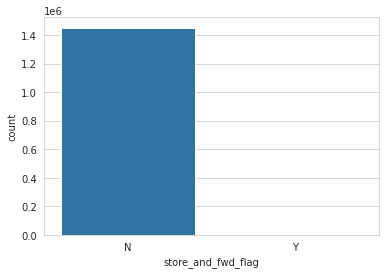

In [36]:
#store_and_fwd_flag
sns.countplot(df['store_and_fwd_flag'])

**4. Trip_duration**


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


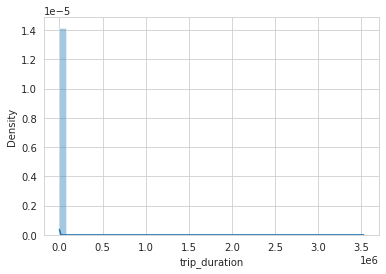

In [37]:
sns.distplot(df['trip_duration'], kde = True)

In [38]:
print(round(df['trip_duration'].describe(),3))

count    1458644.000
mean         959.492
std         5237.432
min            1.000
25%          397.000
50%          662.000
75%         1075.000
max      3526282.000
Name: trip_duration, dtype: float64


In [39]:
# there are wide range in the data lets look it percentile wize
for i in range(0,101,10):
  print(f'the {i}th percentile value is ',df['trip_duration'].quantile(i/100))

the 0th percentile value is  1.0
the 10th percentile value is  245.0
the 20th percentile value is  348.0
the 30th percentile value is  446.0
the 40th percentile value is  548.0
the 50th percentile value is  662.0
the 60th percentile value is  798.0
the 70th percentile value is  968.0
the 80th percentile value is  1208.0
the 90th percentile value is  1634.0
the 100th percentile value is  3526282.0


In [40]:
## it can oberseved that the range in 90th to 100th percentile is very high, so lets get deep into that
for i in range(90,101,1):
  print(f'the {i}th percentile value is ',df['trip_duration'].quantile(i/100))

the 90th percentile value is  1634.0
the 91th percentile value is  1703.0
the 92th percentile value is  1780.0
the 93th percentile value is  1869.0
the 94th percentile value is  1975.0
the 95th percentile value is  2104.0
the 96th percentile value is  2273.0
the 97th percentile value is  2497.0
the 98th percentile value is  2829.0
the 99th percentile value is  3440.0
the 100th percentile value is  3526282.0


In [41]:
## In a day maximum 24 hours i.e, 86400 seconds occurs, so lets see the trips having trip_duration more than a day

df[df['trip_duration'] > 86400].shape

## so total 4 trips which took more than a day. 

(4, 20)

**observation** 
<br> (1) According to  NYC Taxi & Limousine Commision Regulations the maximum allowed trip duration in a 24 hour interval is 12 hours so any value greater than 43200 sec is an outlier.
<br>(2) Since mean > median, the curve is right skewed.
<br>(3) there are 4 trips having duration more than a day, it could be the weekend long drives or an outlier.
<br> (4) There is a huge gap in the 99th percentile value and the 100th percentile value.

**5. Trip distance**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


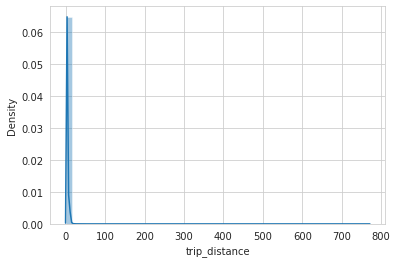

In [42]:
sns.distplot(df['trip_distance'], kde = True)

In [43]:
print(round(df['trip_distance'].describe(),3))

count    1458644.000
mean           2.138
std            2.670
min            0.000
25%            0.765
50%            1.301
75%            2.408
max          771.066
Name: trip_distance, dtype: float64


In [44]:
# there are wide range in the data lets look it percentile wize
for i in range(0,101,10):
  print(f'the {i}th percentile value is ',df['trip_distance'].quantile(i/100))

the 0th percentile value is  0.0
the 10th percentile value is  0.49242891407622
the 20th percentile value is  0.6770481928125682
the 30th percentile value is  0.8574249312571905
the 40th percentile value is  1.0602718213609397
the 50th percentile value is  1.3009773489187393
the 60th percentile value is  1.61399677135551
the 70th percentile value is  2.073466523960667
the 80th percentile value is  2.870470532237082
the 90th percentile value is  4.741588132608124
the 100th percentile value is  771.0659931138583


In [45]:
# The 90th percentile value is 7.631 km, however the 100th percentile value is 1240.910 km so lets dive into the details
for i in range(90,101,1):
  print(f'the {i}th percentile value is ',df['trip_distance'].quantile(i/100))

the 90th percentile value is  4.741588132608124
the 91th percentile value is  5.129879727735619
the 92th percentile value is  5.522844981875209
the 93th percentile value is  5.8766081091538656
the 94th percentile value is  6.264551399812679
the 95th percentile value is  6.847088498922473
the 96th percentile value is  7.963432727462154
the 97th percentile value is  9.579550111890612
the 98th percentile value is  12.035627296389581
the 99th percentile value is  12.916783802753425
the 100th percentile value is  771.0659931138583


In [46]:
for i in range(990,1001,1):
  print(f'the {i/10}th percentile value is ',df['trip_distance'].quantile(i/1000))

the 99.0th percentile value is  12.916783802753425
the 99.1th percentile value is  12.999197615118106
the 99.2th percentile value is  13.080806174793503
the 99.3th percentile value is  13.164786156413818
the 99.4th percentile value is  13.276180042956625
the 99.5th percentile value is  13.395148176560276
the 99.6th percentile value is  13.565917872909674
the 99.7th percentile value is  13.834822134823334
the 99.8th percentile value is  14.22310478956466
the 99.9th percentile value is  15.3893717338993
the 100.0th percentile value is  771.0659931138583


**observation**<br> (1) There are some values with zero trip distance it might be corresponding to the one second time duration.
<br> (2) There are much difference between 99.9th percentile and 100th percentile value is significant, so we can treat the value above 99.9 percentile as outlier.
<br> (3) mean distance > median so the curve will be similat to the trip_duration curve.

**6.Pickup and dropoff day**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


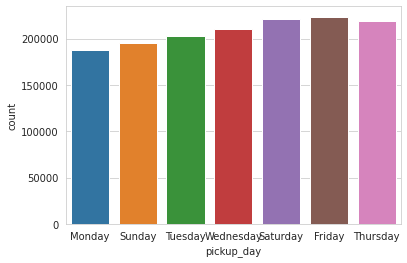

In [47]:
# pickup day
sns.countplot(df['pickup_day'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


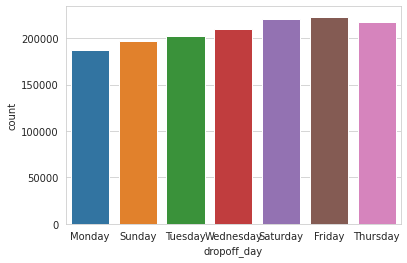

In [48]:
sns.countplot(df['dropoff_day'])

<br> both  the graph are similar, friday and saturday have maximum number of trips.

**7. pickup and dropoff month**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


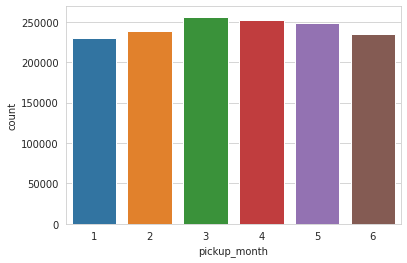

In [49]:
sns.countplot(df['pickup_month'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


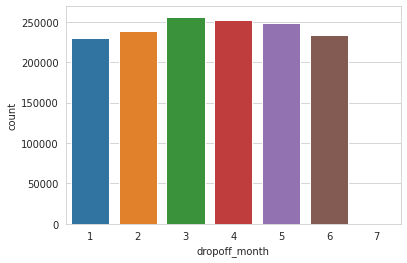

In [50]:
sns.countplot(df['dropoff_month'])

<br> pickup and dropoff month both have similar graph.

**8.Longitude and latitude**

<br> New York is bounded by the location cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004), however there are many coordinates which lie outside the bounded region for pickups and dropoffs

In [51]:
#pip install folium 

**Pickup Location**

In [52]:
outlier_locations = df[((df.pickup_longitude <= -74.15) | (df.pickup_latitude <= 40.5774)| \
                   (df.pickup_longitude >= -73.7004) | (df.pickup_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

**observation**
<br> (1) There are many pickups outside the newyork city as it can be seen, infact some pickup locations are in middle of the ocean.
<br> (2) All the points located in map can be treated as outliers.

**dropoff location**

In [53]:
outlier_locations = df[((df.dropoff_longitude <= -74.15) | (df.dropoff_latitude <= 40.5774)| \
                   (df.dropoff_longitude >= -73.7004) | (df.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample_locations = outlier_locations.head(10000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

**observation**
<br> (1) There are many pickups outside the newyork city as it can be seen, infact some pickup locations are in middle of the ocean.
<br> (2) All the points located in map can be treated as outliers.

## Outlier removal

<br> Following can be treated as outlier:
<br>(1) data having passenger count >= 6 and 0
<br>(2) data having trip_duration greater than 43200 sec i.e., 12 hours
<br>(3) trip distance greater than 99.9 percentile or 15.389 miles 
<br>(4) pickup and dropoff locations not in range of cordinates(lat,long) - (40.5774, -74.15) & (40.9176,-73.7004)

In [54]:
def outlier_removal_function(df):
  ''' 
  This function is used for outlier removal in this project
  '''
  # passenger_count
  df1 = df[(df['passenger_count'] <= 6) & (df['passenger_count'] != 0)]
  data_loss_pass = df.shape[0]-df1.shape[0]
  print(" data loss by passenger_count outlier is ", data_loss_pass*100/df.shape[0],"%")

  # Trip_duration greater than 43200
  df2 = df1[df1['trip_duration'] <= 43200]
  data_loss_dur = df1.shape[0]-df2.shape[0]
  print(" data loss by trip duration ", data_loss_dur*100/df.shape[0],"%")

  # trip distance greater than 15.389 miles
  df3 = df2[df2['trip_distance'] <= 15.389]
  data_loss_dis = df2.shape[0]-df3.shape[0]
  print("data loss by trip_duration ", data_loss_dis*100/df.shape[0],"%")

  # longitude and latitude
  df4 = df3[(df3['pickup_latitude'] >= 40.5774) & (df3['pickup_latitude'] <= 40.9176)]
  df5 = df4[(df4['pickup_longitude'] >=(-74.15)) & (df4['pickup_longitude'] <= (-73.7004))]

  df6 = df5[(df5['dropoff_latitude'] >= 40.5774) & (df5['dropoff_latitude'] <= 40.9176)]
  df7 = df6[(df6['dropoff_longitude'] >=(-74.15)) & (df6['pickup_longitude'] <= (-73.7004))]

  data_loss_lat_long = df3.shape[0] - df7.shape[0]
  print("data loss by location ", data_loss_lat_long*100/df.shape[0],"%")

  # Total data loss
  tot_data_loss = df.shape[0] - df7.shape[0]
  print("total data loss is ", tot_data_loss*100/df.shape[0])

  return df7



In [55]:
## data after outlier removal
new_df =  outlier_removal_function(df)

 data loss by passenger_count outlier is  0.004456193560594635 %
 data loss by trip duration  0.13656519342622325 %
data loss by trip_duration  0.09975017893331066 %
data loss by location  0.23453289493529608 %
total data loss is  0.4753044608554246


**Bivariate analysis**

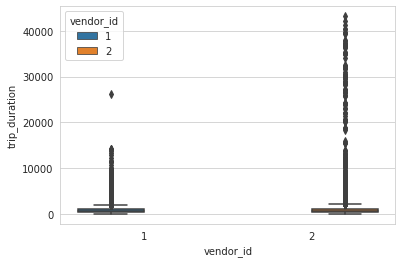

In [56]:
# vendor_id vs trip duration
sns.boxplot(data = new_df, x = 'vendor_id', y ='trip_duration', hue='vendor_id')


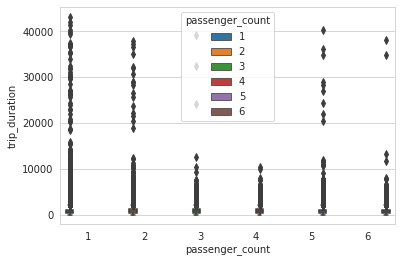

In [57]:
sns.boxplot(data =new_df, x = 'passenger_count', y ='trip_duration', hue='passenger_count')


<br> 60 trip have zero pessanger count, 1 trip have 7,8 and 9 passenger counts.


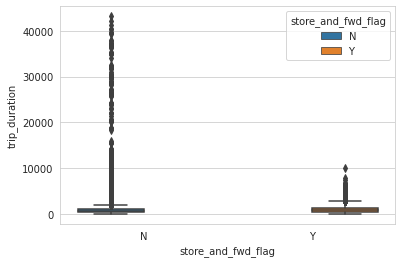

In [58]:
sns.boxplot(data =new_df, x = 'store_and_fwd_flag', y ='trip_duration', hue='store_and_fwd_flag')

Text(0.5, 1.0, 'trip_distance vs trip_duration')

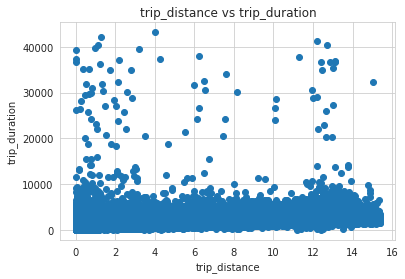

In [59]:
plt.scatter(new_df['trip_distance'],new_df['trip_duration'])
plt.xlabel("trip_distance")
plt.ylabel("trip_duration")
plt.title("trip_distance vs trip_duration")

In [60]:

#plt.scatter(new_data1['pickup_latitude'],new_data1['pickup_longitude'],'r')
#plt.scatter(new_data1['dropoff_latitude'],new_data1['dropoff_longitude','g'])
#plt.xlabel("Latitude")
#plt.ylabel("Longitude")
#plt.show()

**Multivariate analysis**

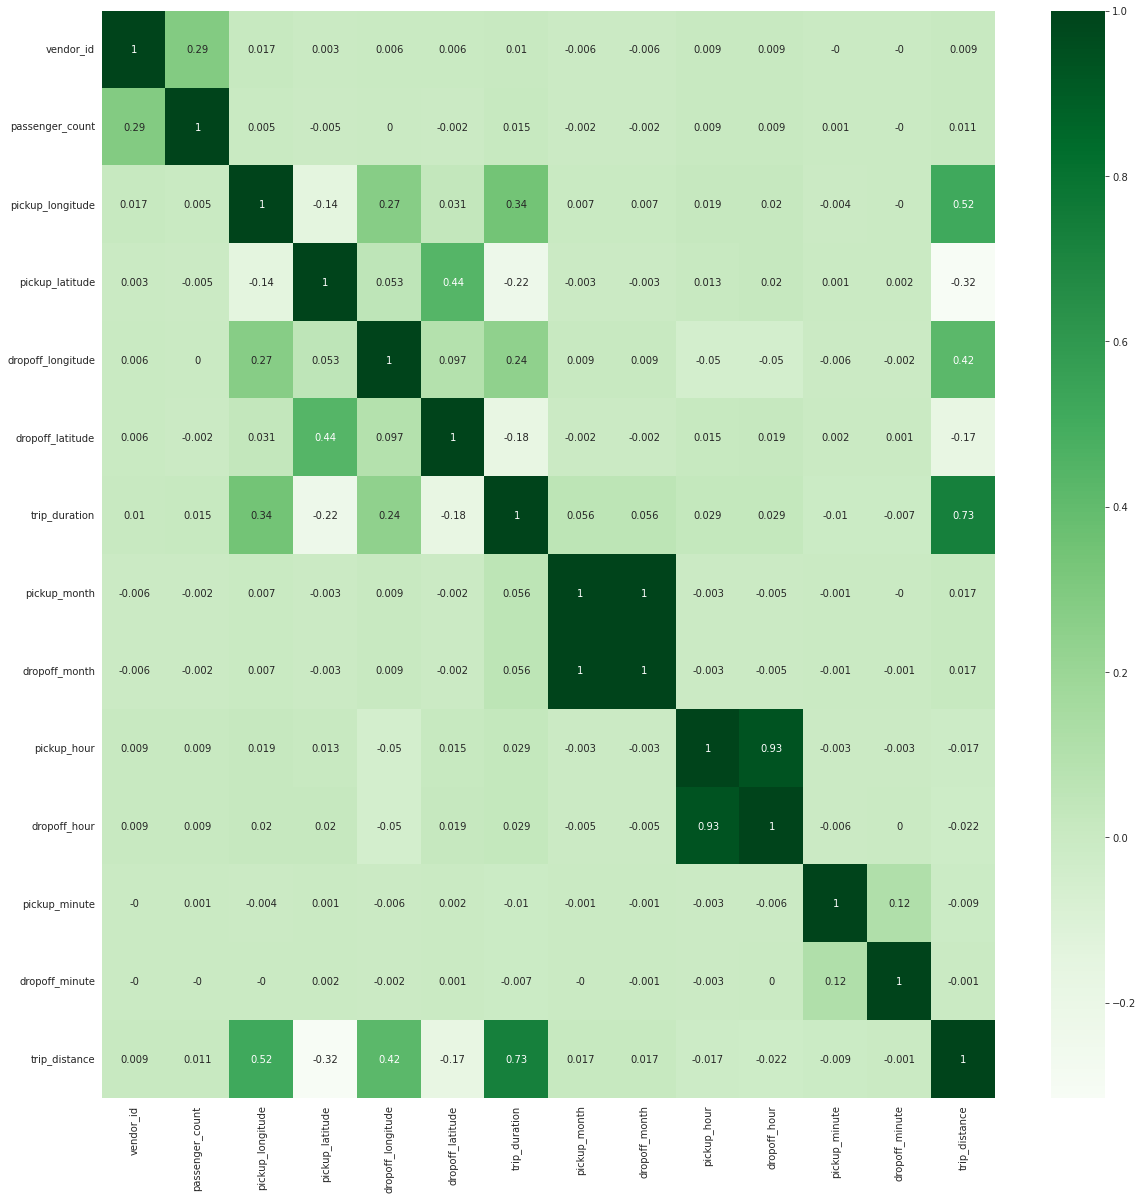

In [61]:
corr = round(new_df.corr(),3)
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap="Greens",annot=True)


## Train test split

In [62]:
new_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_month',
       'dropoff_month', 'pickup_hour', 'dropoff_hour', 'pickup_minute',
       'dropoff_minute', 'trip_distance'],
      dtype='object')

In [75]:
# since our target variable is trip_duration 
Y = new_df['trip_duration']
# Keeping pickup datetime to perform time based splitting
X = new_df[['vendor_id','passenger_count','store_and_fwd_flag','pickup_day', 'dropoff_day', 'pickup_month',
       'dropoff_month', 'pickup_hour', 'dropoff_hour', 'pickup_minute',
       'dropoff_minute', 'trip_distance','pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude']]

In [76]:
X.head()

,vendor_id,passenger_count,store_and_fwd_flag,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_hour,dropoff_hour,pickup_minute,dropoff_minute,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,2,1,N,Monday,Monday,3,3,17,17,24,32,0.931139,-73.982155,40.767937,-73.964630,40.765602
1,1,1,N,Sunday,Sunday,6,6,0,0,43,54,1.121892,-73.980415,40.738564,-73.999481,40.731152
2,2,1,N,Tuesday,Tuesday,1,1,11,12,35,10,3.967522,-73.979027,40.763939,-74.005333,40.710087
3,2,1,N,Wednesday,Wednesday,4,4,19,19,32,39,0.923047,-74.010040,40.719971,-74.012268,40.706718
4,2,1,N,Saturday,Saturday,3,3,13,13,30,38,0.738556,-73.973053,40.793209,-73.972923,40.782520


**Understanding target variable**

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


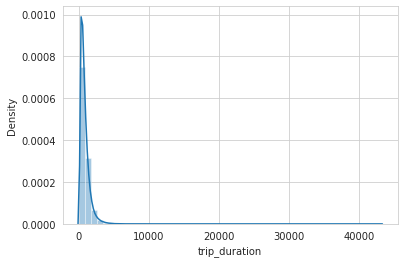

In [77]:
sns.distplot(new_df['trip_duration'], kde = True)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


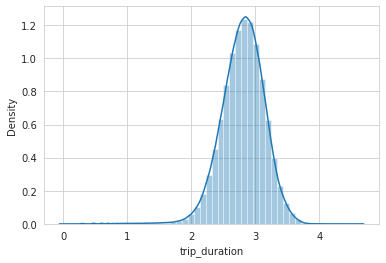

In [78]:
# Plot seems to be log_normal lets try it
sns.distplot(np.log10(new_df['trip_duration']), kde = True)

Initially the target variable seems to be the log-normal distribution, but after plotting the log of the value it has slightly longer tail in left sie. So, to confirm it we plot QQ plot.

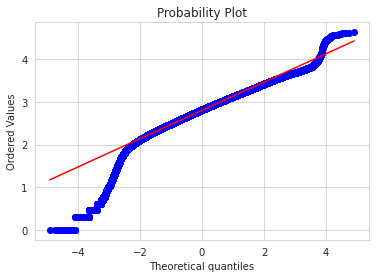

In [79]:
#Q-Q plot for checking if trip-times is log-normal
scipy.stats.probplot(np.log10(new_df['trip_duration']).values, plot=plt)
plt.show()

From above plot it can be observed that in between -2 to 2 it acts as normal distribution and apart from this it is not. So we confirm that it is not a log normal distribution.

In [80]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state = 0)
print("The shape of x_train and y_train are: ", x_train.shape,"and", y_train.shape) 
print("The shape of x_test and y_test are: ", x_test.shape,"and", y_test.shape)

The shape of x_train and y_train are:  (1088783, 16) and (1088783,)
The shape of x_test and y_test are:  (362928, 16) and (362928,)


**Data preparation**

In [81]:
x_train.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pickup_day',
       'dropoff_day', 'pickup_month', 'dropoff_month', 'pickup_hour',
       'dropoff_hour', 'pickup_minute', 'dropoff_minute', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude'],
      dtype='object')

(1) catogorical type: vendor_id, passenger_count,store_and_fwd_flag,pickup_day,dropoff_day, pickup_month, dropoff_month, pickup_hour, dropoff_hour, pickup_minute, dropoff_minute
<br>(2) Numerical type : trip_distance,'pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'

In [70]:
# converting categorical into numerical

#x_train1 = pd.get_dummies(x_train, drop_first = True)
#x_test1 = pd.get_dummies(x_test,drop_first = True)

# since performing this at once, it is not considering vendor_id and passenger_count as categorical so lets perform one by one and concat them

def pandas_get_dummies(df,col):
  df1 = pd.get_dummies(df[col], drop_first = True)
  return df1

In [84]:
# vendor_id
vendor_id_dum_tr = np.asarray(pandas_get_dummies(x_train,'vendor_id'))
vendor_id_dum_te = np.asarray(pandas_get_dummies(x_test,'vendor_id'))
print("Shape of vendor id categorical", vendor_id_dum_tr.shape,"and", vendor_id_dum_te.shape)
print("-"*50)

# passenger_count
passenger_count_dum_tr = np.asarray(pandas_get_dummies(x_train,'passenger_count'))
passenger_count_dum_te = np.asarray(pandas_get_dummies(x_test,'passenger_count'))
print("Shape of passenger_count categorical", passenger_count_dum_tr.shape,"and", passenger_count_dum_te.shape)
print("-"*50)

# store_and_fwd_flag
store_and_fwd_flag_dum_tr = np.asarray(pandas_get_dummies(x_train,'store_and_fwd_flag'))
store_and_fwd_flag_dum_te = np.asarray(pandas_get_dummies(x_test,'store_and_fwd_flag'))
print("Shape of store_and_fwd_flag categorical", store_and_fwd_flag_dum_tr.shape,"and", store_and_fwd_flag_dum_te.shape)
print("-"*50)

# pickup_day
pickup_day_dum_tr = np.asarray(pandas_get_dummies(x_train,'pickup_day'))
pickup_day_dum_te = np.asarray(pandas_get_dummies(x_test,'pickup_day'))
print("Shape of pickup_day categorical", pickup_day_dum_tr.shape,"and", pickup_day_dum_te.shape)
print("-"*50)

# dropoff_day
dropoff_day_dum_tr = np.asarray(pandas_get_dummies(x_train,'dropoff_day'))
dropoff_day_dum_te = np.asarray(pandas_get_dummies(x_test,'dropoff_day'))
print("Shape of dropoff_day categorical", dropoff_day_dum_tr.shape,"and", dropoff_day_dum_te.shape)
print("-"*50)

# pickup_month
pickup_month_dum_tr = np.asarray(pandas_get_dummies(x_train,'pickup_month'))
pickup_month_dum_te = np.asarray(pandas_get_dummies(x_test,'pickup_month'))
print("Shape of pickup_month categorical", pickup_month_dum_tr.shape,"and", pickup_month_dum_te.shape)
print("-"*50)

# dropoff_month
dropoff_month_dum_tr = np.asarray(pandas_get_dummies(x_train,'dropoff_month'))
dropoff_month_dum_te = np.asarray(pandas_get_dummies(x_test,'dropoff_month'))
print("Shape of dropoff_month categorical", dropoff_month_dum_tr.shape,"and", dropoff_month_dum_te.shape)
print("-"*50)

# pickup_hour
pickup_hour_dum_tr = np.asarray(pandas_get_dummies(x_train,'pickup_hour'))
pickup_hour_dum_te = np.asarray(pandas_get_dummies(x_test,'pickup_hour'))
print("Shape of pickup_hour categorical", pickup_hour_dum_tr.shape,"and", pickup_hour_dum_te.shape)
print("-"*50)

# dropoff_hour
dropoff_hour_dum_tr = np.asarray(pandas_get_dummies(x_train,'dropoff_hour'))
dropoff_hour_dum_te = np.asarray(pandas_get_dummies(x_test,'dropoff_hour'))
print("Shape of dropoff_hour categorical", dropoff_hour_dum_tr.shape,"and", dropoff_hour_dum_te.shape)
print("-"*50)

# pickup_minute
pickup_minute_dum_tr = np.asarray(pandas_get_dummies(x_train,'pickup_minute'))
pickup_minute_dum_te = np.asarray(pandas_get_dummies(x_test,'pickup_minute'))
print("Shape of pickup_minute categorical", pickup_minute_dum_tr.shape,"and", pickup_minute_dum_te.shape)
print("-"*50)

# dropoff_minute
dropoff_minute_dum_tr = np.asarray(pandas_get_dummies(x_train,'dropoff_minute'))
dropoff_minute_dum_te = np.asarray(pandas_get_dummies(x_test,'dropoff_minute'))
print("Shape of dropoff_minute categorical", dropoff_minute_dum_tr.shape,"and", dropoff_minute_dum_te.shape)
print("-"*50)


Shape of vendor id categorical (1088783, 1) and (362928, 1)
--------------------------------------------------
Shape of passenger_count categorical (1088783, 5) and (362928, 5)
--------------------------------------------------
Shape of store_and_fwd_flag categorical (1088783, 1) and (362928, 1)
--------------------------------------------------
Shape of pickup_day categorical (1088783, 6) and (362928, 6)
--------------------------------------------------
Shape of dropoff_day categorical (1088783, 6) and (362928, 6)
--------------------------------------------------
Shape of pickup_month categorical (1088783, 5) and (362928, 5)
--------------------------------------------------
Shape of dropoff_month categorical (1088783, 6) and (362928, 6)
--------------------------------------------------
Shape of pickup_hour categorical (1088783, 23) and (362928, 23)
--------------------------------------------------
Shape of dropoff_hour categorical (1088783, 23) and (362928, 23)
------------------

In [74]:
# To remove the scale effect lets normalize the numerical data
def normalization(X_train, X_test, col1):
    normalizer = Normalizer()
    normalizer.fit(X_train[col1].values.reshape(-1,1))
    
    X_train_norm = normalizer.transform(X_train[col1].values.reshape(-1,1))
    X_test_norm= normalizer.transform(X_test[col1].values.reshape(-1,1))
    return X_train_norm, X_test_norm
  

In [82]:
trip_dis_tr_nor,trip_dis_te_nor = normalization(x_train, x_test, 'trip_distance')

In [83]:
## converting latitude longitude into an array
lat_long_dat_tr = np.asarray(x_train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude']])
lat_long_dat_te = np.asarray(x_test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude']])

In [87]:
# Lets merge all the dataset

x_train_final = np.hstack((vendor_id_dum_tr,passenger_count_dum_tr,store_and_fwd_flag_dum_tr,pickup_day_dum_tr,dropoff_day_dum_tr,pickup_month_dum_tr,dropoff_month_dum_tr,pickup_hour_dum_tr,dropoff_hour_dum_tr,pickup_minute_dum_tr,dropoff_minute_dum_tr,trip_dis_tr_nor, lat_long_dat_tr))
x_test_final = np.hstack((vendor_id_dum_te,passenger_count_dum_te,store_and_fwd_flag_dum_te,pickup_day_dum_te,dropoff_day_dum_te,pickup_month_dum_te,dropoff_month_dum_te,pickup_hour_dum_te,dropoff_hour_dum_te,pickup_minute_dum_te,dropoff_minute_dum_te,trip_dis_te_nor,lat_long_dat_te))
print(x_train_final.shape)
print(x_test_final.shape)

(1088783, 199)
(362928, 199)


## Model Training 

<br> In this section we will train bunch of machine learning models along with the hyperparameter tuning. The models we train are following:
<br> (1) Linear regression
<br> (2) Lasso regression
<br> (3) SVM Regressor
<br> (4) Decision tree
<br> (5) Random forest
<br> (6) Gradient Boosting Decision Tree

**1. Linear Regression**